# Variational Autoencoders: Advanced topics

In this notebook, we will learn two useful extensions of VAEs: the disentangled VAEs ($\beta$-VAEs) and the conditional VAEs. You should have completed [VAE_basics.ipynb](VAE_basics.ipynb) before attempting this notebook.

In [1]:
# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# check version
print('Using TensorFlow v%s' % tf.__version__)
acc_str = 'accuracy' if tf.__version__[:2] == '2.' else 'acc'

# helpers
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')


# need certainty to explain some of the results
import random as python_random
python_random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

Using TensorFlow v2.3.1


# The Dataset

In this notebook, we will use the `mnist-digits` dataset. It is simpler than the `mnist-fashion` dataset, allowing us to use only two latent features so that we can conveniently visualise and examine the encodings distribution in the latent space.

In [2]:
# load dataset
(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()

# normalise images
train_images = train_images / 255.0
test_images = test_images / 255.0

# print info
print("Number of training data: %d" % len(train_labels))
print("Number of test data: %d" % len(test_labels))
print("Image pixels: %s" % str(train_images[0].shape))
print("Number of classes: %d" % (np.max(train_labels) + 1))

Number of training data: 60000
Number of test data: 10000
Image pixels: (28, 28)
Number of classes: 10


# Disentangled Variational Autoencoders

Disentangled VAEs or $\beta$-VAEs are an extended type of VAEs. As explained before, the loss of a VAE consists of two parts, the reconstruction error and the KL divergence: the former tries to fit the network with data and the later to regularise the latent space. It is thus natural to introduce a hyperparameter to weigh these two forces, which gives rise to a disentangled VAE. As you can see in the following cartoon, a factor $\beta$ is applied to the KL divergence, and this $\beta$ is usually greater than 1. In practice, the value of $\beta$ has to be tuned for the best quality of content generation.

So, why we call it "disentangled"? Consider the limit $\beta\rightarrow\infty$: in this case, the distributions of all the latent features will simply converge to $\mathcal{N}(0,1)$, regardless of the data, so they are completely disentangled. In other words, the latent features become increasingly disentangled as $\beta$ increases. 


![bvae.png](https://github.com/stfc-sciml/sciml-workshop-v3/blob/master/course_3.0_with_solutions/markdown_pic/bvae.png?raw=1)

## 1. Implement a $\beta$-VAE

It is straightforward to generalise our VAE implementation: just adding $\beta$ as a hyperparameter to the constructor of the `VAE` class and apply it to the KL divergence in the `train_step()` method. The differences are highlighted in the code.


### The encoder and decoder

They are exactly the same as before in the VAE example.

In [3]:
latent_dim = 2
# sampling z with (z_mean, z_log_var)
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.keras.backend.random_normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
# build the encoder
image_input = keras.Input(shape=(28, 28))
x = layers.Flatten()(image_input)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z_output = Sampling()([z_mean, z_log_var])
encoder_BVAE = keras.Model(image_input, [z_mean, z_log_var, z_output])

# build the decoder
z_input = keras.Input(shape=(latent_dim,))
x = layers.Dense(16, activation="relu")(z_input)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(28 * 28, activation="sigmoid")(x)
image_output = layers.Reshape((28, 28))(x)
decoder_BVAE = keras.Model(z_input, image_output)

### The $\beta$-VAE

We will use $\beta=10$ for demonstration. Try some other values (particularly a very large value such as 1000) and see what happens.

In [4]:
# BVAE class
class BVAE(keras.Model):
    # constructor
    ########################################################
    ######## NEW: passing beta as an extra argument ########
    ########################################################
    def __init__(self, encoder, decoder, beta, **kwargs):
        super(BVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta

    # customise train_step() to implement the loss 
    def train_step(self, x):
        if isinstance(x, tuple):
            x = x[0]
        with tf.GradientTape() as tape:
            # encoding
            z_mean, z_log_var, z = self.encoder(x)
            # decoding
            x_prime = self.decoder(z)
            # reconstruction error by binary crossentropy loss
            reconstruction_loss = tf.reduce_mean(keras.losses.binary_crossentropy(x, x_prime)) * 28 * 28
            # KL divergence
            kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            # loss = reconstruction error + KL divergence
            #######################################
            ######## NEW: scale KL by beta ########
            #######################################
            loss = reconstruction_loss + self.beta * kl_loss
        # apply gradient
        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        # return loss for metrics log
        return {"loss": loss,
                "reconstruction_loss": reconstruction_loss,
                "kl_loss": kl_loss}

# build the BVAE
########################################
######## NEW: pass beta to BVAE ########
########################################
bvae_model = BVAE(encoder_BVAE, decoder_BVAE, beta=10.)

# compile the BVAE
bvae_model.compile(optimizer=keras.optimizers.Adam())

# train the BVAE
bvae_model.fit(train_images, train_images, epochs=50, batch_size=128)

Epoch 1/50
469/469 [==============================] - 2s 4ms/step - loss: 223.2019 - reconstruction_loss: 213.1419 - kl_loss: 1.0060
Epoch 2/50
469/469 [==============================] - 2s 4ms/step - loss: 188.3249 - reconstruction_loss: 177.9583 - kl_loss: 1.0367
Epoch 3/50
469/469 [==============================] - 2s 4ms/step - loss: 184.0132 - reconstruction_loss: 171.9222 - kl_loss: 1.2091
Epoch 4/50
469/469 [==============================] - 2s 4ms/step - loss: 182.0643 - reconstruction_loss: 169.0871 - kl_loss: 1.2977
Epoch 5/50
469/469 [==============================] - 2s 4ms/step - loss: 180.7325 - reconstruction_loss: 167.3061 - kl_loss: 1.3426
Epoch 6/50
469/469 [==============================] - 2s 4ms/step - loss: 179.4907 - reconstruction_loss: 165.5178 - kl_loss: 1.3973
Epoch 7/50
469/469 [==============================] - 2s 4ms/step - loss: 178.3636 - reconstruction_loss: 163.8865 - kl_loss: 1.4477
Epoch 8/50
469/469 [==============================] - 2s 4ms/step - l

## 2. Evaluate the results

The same as before, we can evaluate the latent distributions and generate new images using our $\beta$-VAE. As expected, the distributions become more close to normal distributions because $\beta=10$. 

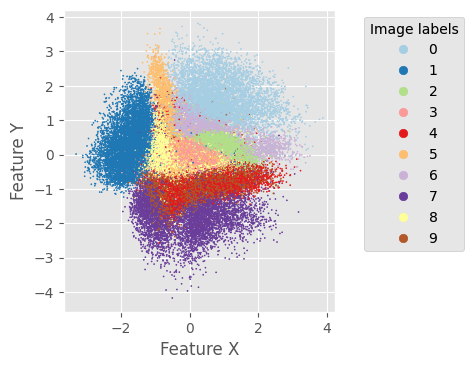

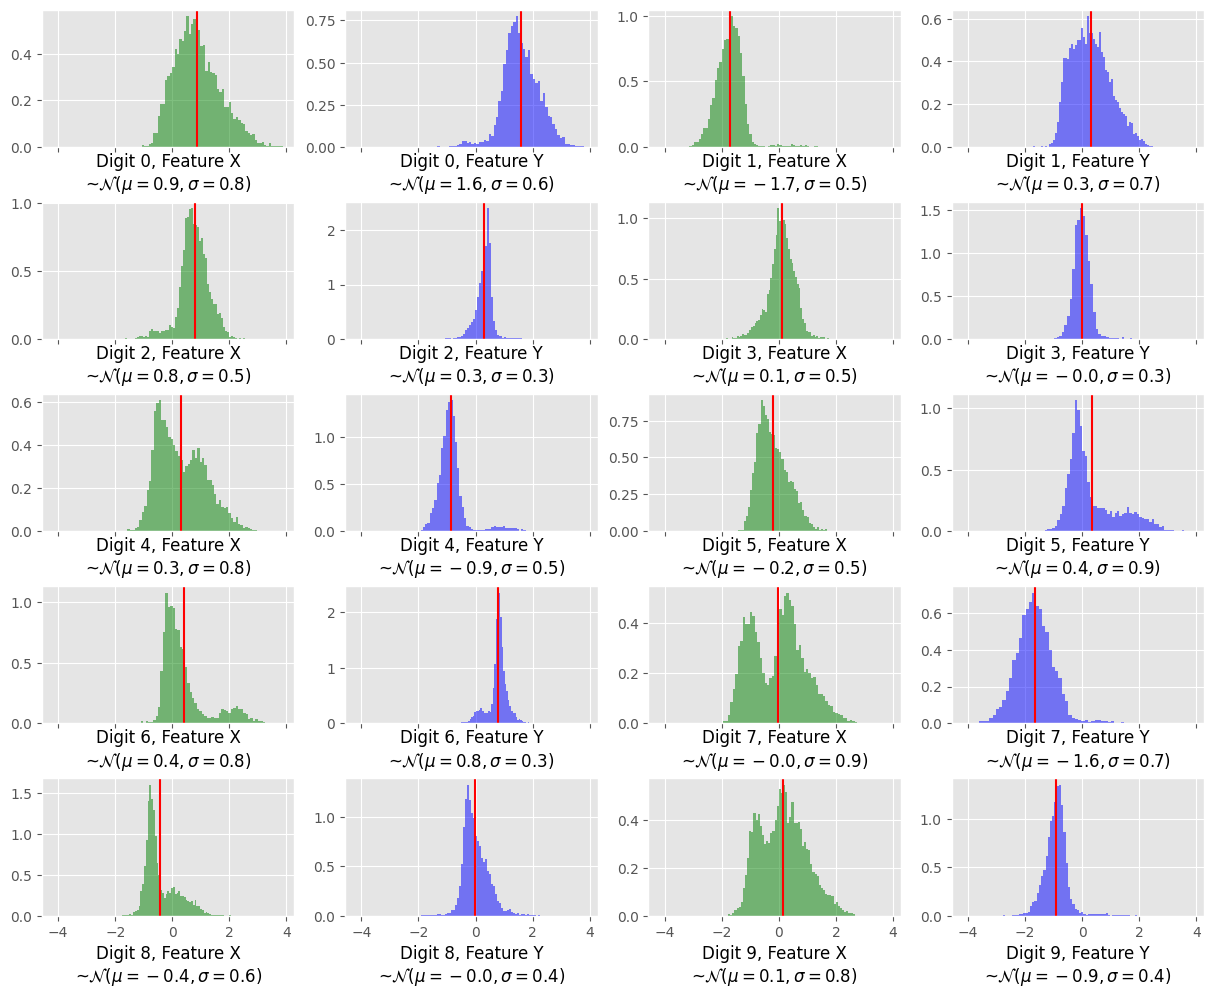

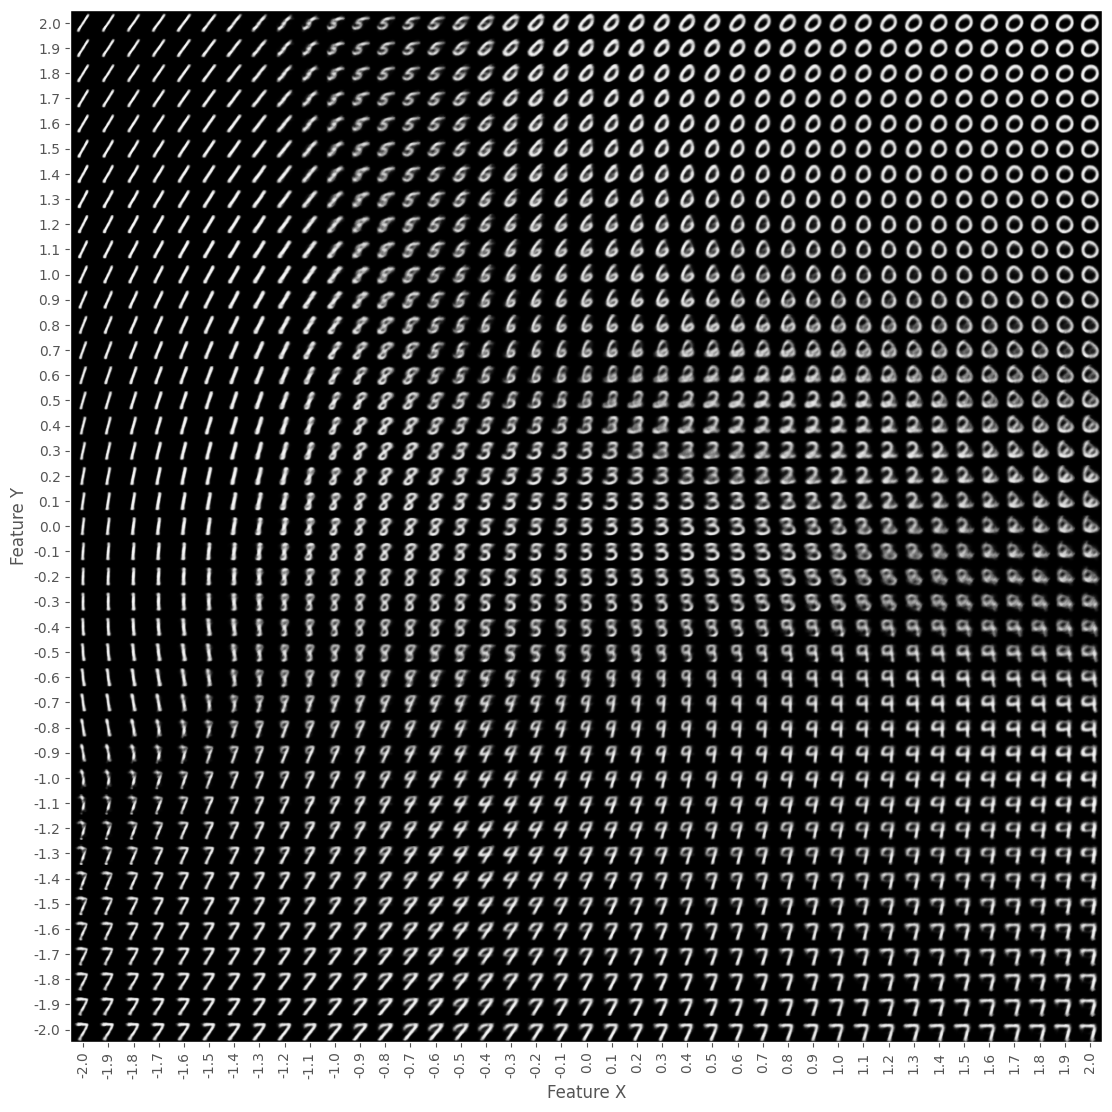

In [5]:
# scatter plot of encodings in the latent space
def scatter_plot_encodings_latent(encodings, labels):
    plt.figure(dpi=100)
    scat = plt.scatter(encodings[:, 0], encodings[:, 1], c=labels, s=.5, cmap='Paired')
    plt.gca().add_artist(plt.legend(*scat.legend_elements(), 
                         title='Image labels', bbox_to_anchor=(1.5, 1.)))
    plt.xlabel('Feature X')
    plt.ylabel('Feature Y')
    plt.gca().set_aspect(1)
    plt.show()
    
# histogram plot of encodings in the latent space
def hist_plot_encodings_latent(encodings, labels, digit, dim, ax):
    # extract
    encodings_digit = encodings[labels == digit, dim]
    # histogram
    ax.hist(encodings_digit, bins=60, density=True, color=['g', 'b'][dim], alpha=.5)
    # mean and std dev
    mean = np.mean(encodings_digit)
    std = np.std(encodings_digit)
    ax.axvline(mean, c='r')
    ax.set_xlabel('Digit %d, Feature %s\n~${\cal N}(\mu=%.1f, \sigma=%.1f)$' % 
                  (digit, ['X', 'Y'][dim], mean, std), c='k')
    
# generate images from the latent space
def generate_images_latent(decoder, x0, x1, dx, y0, y1, dy):
    # uniformly sample the latent space
    nx = round((x1 - x0) / dx) + 1
    ny = round((y1 - y0) / dy) + 1
    grid_x = np.linspace(x0, x1, nx)
    grid_y = np.linspace(y1, y0, ny)
    latent = np.array(np.meshgrid(grid_x, grid_y)).reshape(2, nx * ny).T

    # decode images
    decodings = decoder.predict(latent)
    
    # display a (nx, ny) 2D manifold of digits
    figure = np.zeros((28 * ny, 28 * nx))
    for iy in np.arange(ny):
        for ix in np.arange(nx):
            figure[iy * 28 : (iy + 1) * 28, ix * 28 : (ix + 1) * 28] = decodings[iy * nx + ix]
            
    # plot figure
    plt.figure(dpi=100, figsize=(nx / 3, ny / 3))
    plt.xticks(np.arange(28 // 2, nx * 28 + 28 // 2, 28), np.round(grid_x, 1), rotation=90)
    plt.yticks(np.arange(28 // 2, ny * 28 + 28 // 2, 28), np.round(grid_y, 1))
    plt.xlabel('Feature X')
    plt.ylabel('Feature Y')
    plt.imshow(figure, cmap="Greys_r")
    plt.grid(False)
    plt.show()
    
# encode images by BVAE
train_encodings_BVAE = encoder_BVAE.predict(train_images)

# scatter plot of encodings by BVAE
scatter_plot_encodings_latent(train_encodings_BVAE[2], train_labels)

# histogram plot of encodings by BVAE
fig, axes = plt.subplots(5, 4, dpi=100, figsize=(15, 12), sharex=True)
plt.subplots_adjust(hspace=.4)
for digit in range(10):
    hist_plot_encodings_latent(train_encodings_BVAE[2], train_labels, digit, 0, 
                               axes[digit // 2, digit % 2 * 2 + 0])
    hist_plot_encodings_latent(train_encodings_BVAE[2], train_labels, digit, 1, 
                               axes[digit // 2, digit % 2 * 2 + 1])
plt.show()

# generate images by BVAE
generate_images_latent(decoder_BVAE, x0=-2, x1=2, dx=.1, y0=-2, y1=2, dy=.1)

# Conditional Variational Autoencoders

In many applications, we hope to generate contents based on the labels. For example, we hope to generate images for a given digit from `mnist-digits`. Conditional VAEs serve this purpose. In a conditional VAE, the labels are sent to both the encoder and the decoder as an extra input, as shown in the following figure. 

<img src="https://github.com/stfc-sciml/sciml-workshop-v3/blob/master/course_3.0_with_solutions/markdown_pic/cvaee.png?raw=1" width=100% height=100% />

## 1. Implement a conditional VAE

The simplest way to implement a conditional VAE is to concatenate the labels to both the input data $x$ and the latent representation $z$. We will use this approach for our implementation. The one-hot encodings of the labels will be concatenated, which is a vector of size 10 (the condition dimension). 

### The encoder

The encoder is the same as that of the VAE except that

1. the input size is increased by the condition dimension; 
2. we no longer flatten the images inside the network because of the concatenation.

In [6]:
# dimension of condition
condition_dim = 10

# encoder
###############################################################
######## NEW: input size is increased by condition_dim ########
###############################################################
image_input = keras.Input(shape=(28 * 28 + condition_dim))
x = layers.Dense(128, activation='relu')(image_input)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z_output = Sampling()([z_mean, z_log_var])
encoder_CVAE = keras.Model(image_input, [z_mean, z_log_var, z_output])
encoder_CVAE.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 794)]        0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 128)          101760      input_3[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 16)           2064        dense_5[0][0]                    
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            34          dense_6[0][0]                    
_______________________________________________________________________________________

### The decoder

The same as the encoder, the input size of the decoder is increased by the condition dimension, and the reconstructed images will be flattened externally.

In [7]:
# decoder
###############################################################
######## NEW: input size is increased by condition_dim ########
###############################################################
z_input = keras.Input(shape=(latent_dim + condition_dim,))
x = layers.Dense(16, activation="relu")(z_input)
x = layers.Dense(128, activation="relu")(x)
image_output = layers.Dense(28 * 28, activation="sigmoid")(x)
decoder_CVAE = keras.Model(z_input, image_output)
decoder_CVAE.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 12)]              0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)                208       
_________________________________________________________________
dense_8 (Dense)              (None, 128)               2176      
_________________________________________________________________
dense_9 (Dense)              (None, 784)               101136    
Total params: 103,520
Trainable params: 103,520
Non-trainable params: 0
_________________________________________________________________


### The conditional VAE

The conditional VAE is the same as the VAE except that

1. the condition dimension is passed to the constructor;
2. the labels are concatenated to the latent features before they are decoded;
3. the labels are truncated from the input data to compute the reconstruction error.

In [8]:
# CVAE class
class CVAE(keras.Model):
    # constructor
    #################################################################
    ######## NEW: passing condition_dim as an extra argument ########
    #################################################################
    def __init__(self, encoder, decoder, condition_dim, **kwargs):
        super(CVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.condition_dim = condition_dim

    # customise train_step() to implement the loss 
    def train_step(self, x):
        if isinstance(x, tuple):
            x = x[0]
        with tf.GradientTape() as tape:
            # encoding
            z_mean, z_log_var, z = self.encoder(x)
            ####################################################################
            ######## NEW: apply conditions to encodings before decoding ########
            ####################################################################
            z_cond = tf.concat([z, x[:, -self.condition_dim:]], axis=1)
            # decoding
            x_prime = self.decoder(z_cond)
            ###################################################################
            ######## NEW: truncate conditions for reconstruction error ########
            ###################################################################
            # reconstruction error by binary crossentropy loss
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(x[:, :-self.condition_dim], x_prime)) * 28 * 28
            # KL divergence
            kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            # loss = reconstruction error + KL divergence
            loss = reconstruction_loss + kl_loss
        # apply gradient
        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        # return loss for metrics log
        return {"loss": loss,
                "reconstruction_loss": reconstruction_loss,
                "kl_loss": kl_loss}

# build the CVAE
cvae_model = CVAE(encoder_CVAE, decoder_CVAE, condition_dim)

# compile the CVAE
cvae_model.compile(optimizer=keras.optimizers.Adam())

## Concatenate the labels

Before training, we need to concatenate the images and their labels to generate the training data.

In [9]:
# one-hot encoding labels
train_labels_onehot = np.eye(10)[train_labels]

# flatten images
train_images_flattened = train_images.reshape((len(train_images), 28 * 28))

# concatenate labels to images
train_images_conditioned = np.concatenate((train_images_flattened, train_labels_onehot), axis=1)

# train the VAE
cvae_model.fit(train_images_conditioned, train_images_flattened, 
               epochs=50, batch_size=128)

Epoch 1/50
469/469 [==============================] - 2s 5ms/step - loss: 197.6432 - reconstruction_loss: 191.3925 - kl_loss: 6.2506
Epoch 2/50
469/469 [==============================] - 2s 4ms/step - loss: 150.3955 - reconstruction_loss: 147.7104 - kl_loss: 2.6852
Epoch 3/50
469/469 [==============================] - 2s 4ms/step - loss: 144.2161 - reconstruction_loss: 141.5377 - kl_loss: 2.6783
Epoch 4/50
469/469 [==============================] - 2s 4ms/step - loss: 140.8955 - reconstruction_loss: 138.2178 - kl_loss: 2.6777
Epoch 5/50
469/469 [==============================] - 3s 6ms/step - loss: 138.7727 - reconstruction_loss: 136.0768 - kl_loss: 2.6959
Epoch 6/50
469/469 [==============================] - 2s 5ms/step - loss: 137.2090 - reconstruction_loss: 134.5139 - kl_loss: 2.6950
Epoch 7/50
469/469 [==============================] - 2s 4ms/step - loss: 135.9986 - reconstruction_loss: 133.2899 - kl_loss: 2.7087
Epoch 8/50
469/469 [==============================] - 2s 4ms/step - l

## 2. Evaluate the results

The latent distributions can be assessed in the same way. Note that *each digit now has its own latent distributions because of the conditioning* (all resemble a $\mathcal{N}(0,1)$), so the latent space is highly regular and disentangled. 

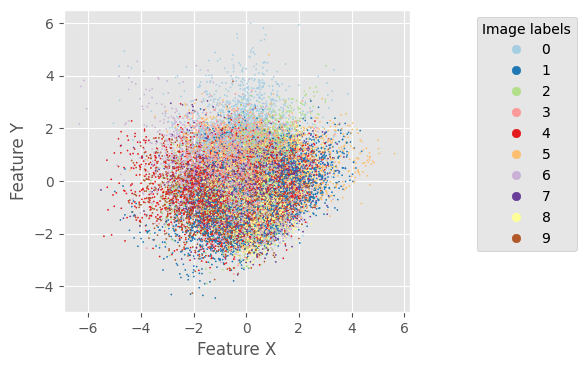

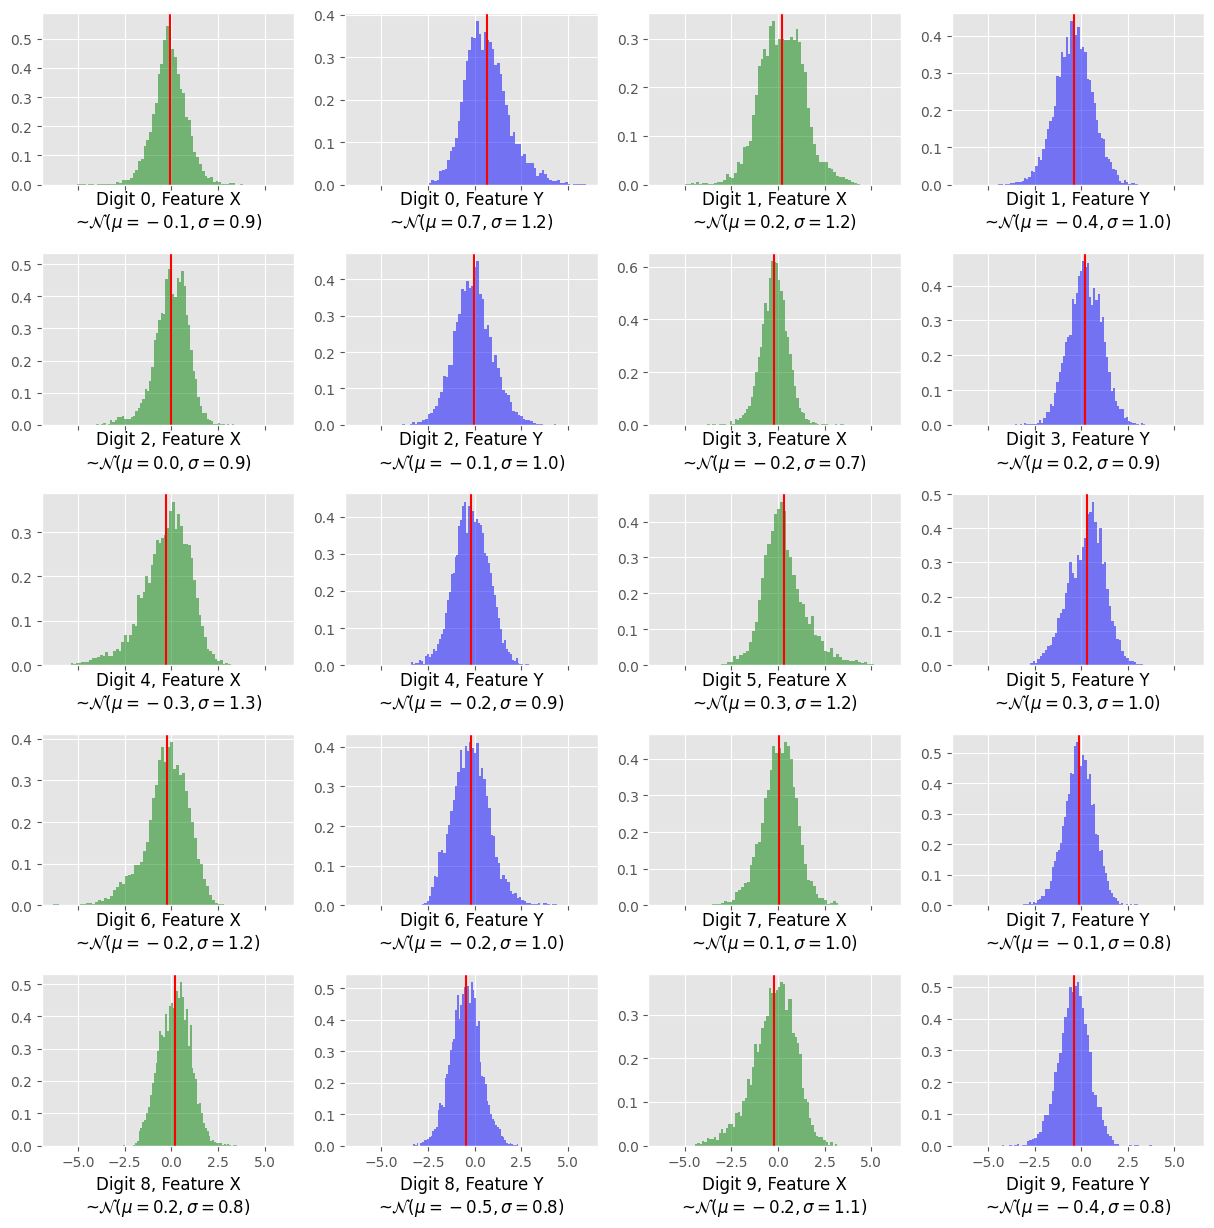

In [10]:
# encode images by CVAE
train_encodings_CVAE = encoder_CVAE.predict(train_images_conditioned)

# scatter plot of encodings by CVAE
scatter_plot_encodings_latent(train_encodings_CVAE[2], train_labels)

# histogram plot of xencodings by CVAE
fig, axes = plt.subplots(5, 4, dpi=100, figsize=(15, 15), sharex=True)
plt.subplots_adjust(hspace=.4)
for digit in range(10):
    hist_plot_encodings_latent(train_encodings_CVAE[2], train_labels, digit, 0, 
                               axes[digit // 2, digit % 2 * 2 + 0])
    hist_plot_encodings_latent(train_encodings_CVAE[2], train_labels, digit, 1, 
                               axes[digit // 2, digit % 2 * 2 + 1])
plt.show()

Finally, we can generate new images for each digit:

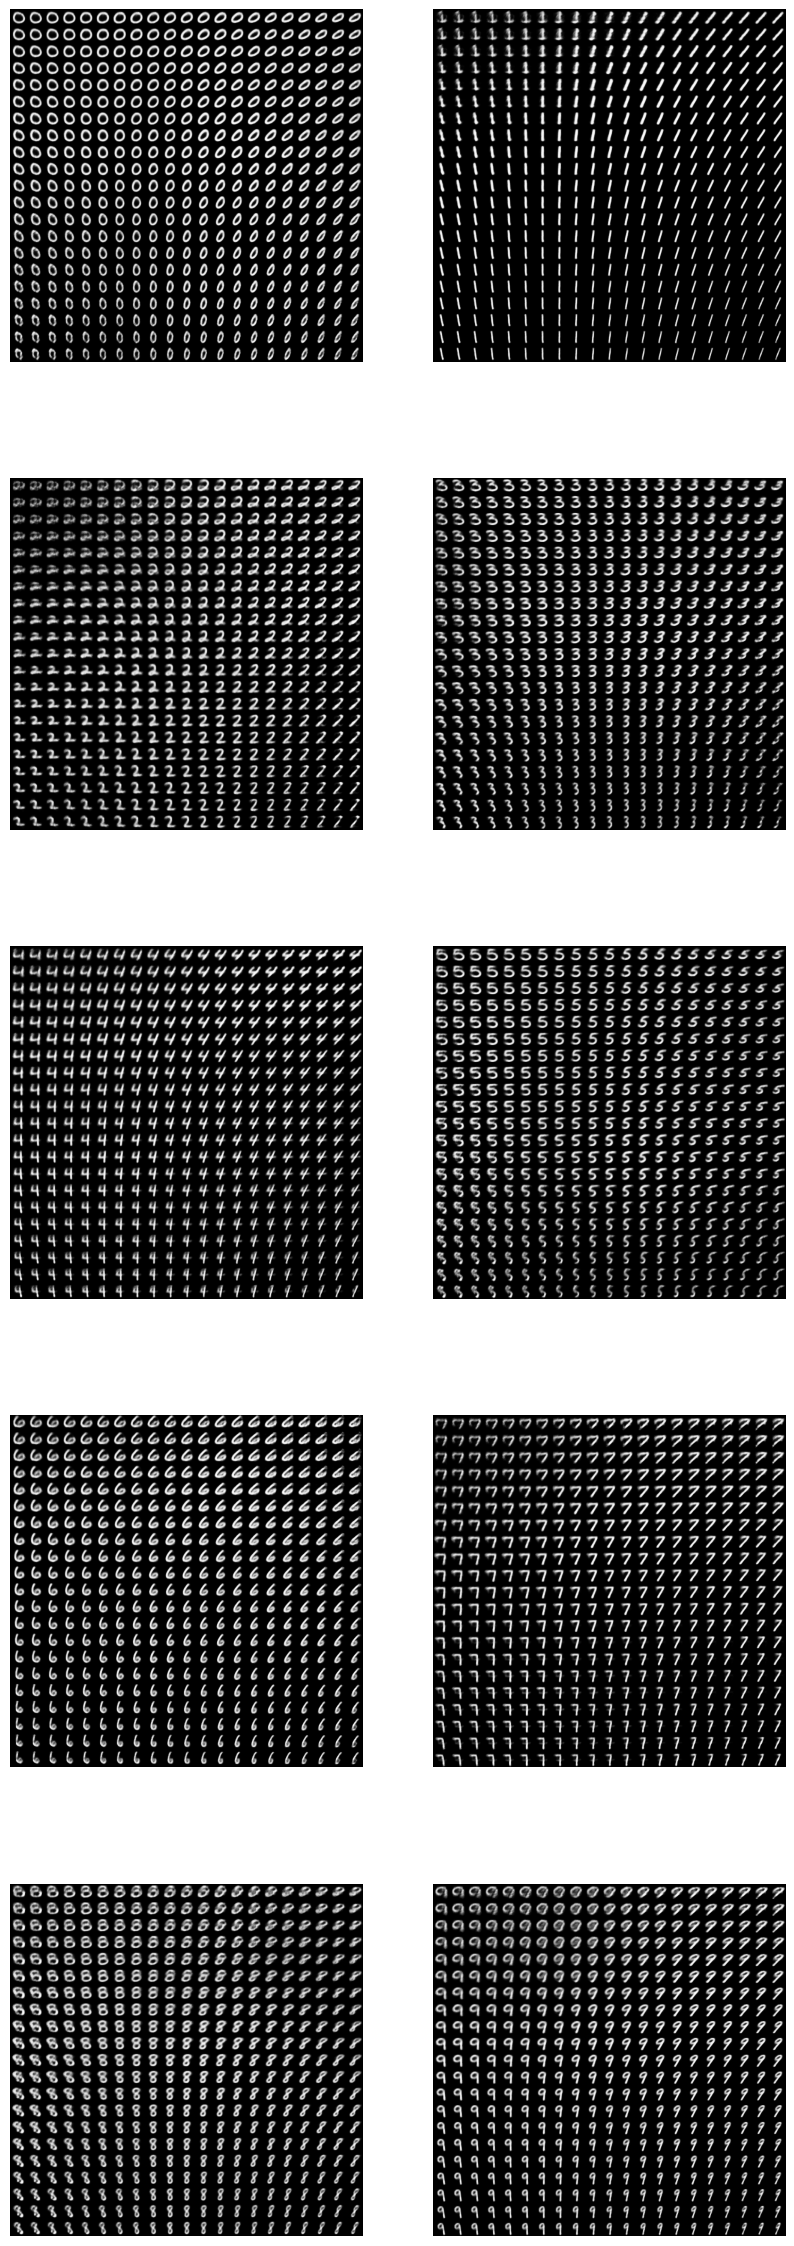

In [11]:
# generate images from the conditioned latent space
def generate_images_conditioned_latent(decoder, x0, x1, dx, y0, y1, dy, condition_digit, ax):
    # uniformly sample the latent space
    nx = round((x1 - x0) / dx) + 1
    ny = round((y1 - y0) / dy) + 1
    grid_x = np.linspace(x0, x1, nx)
    grid_y = np.linspace(y1, y0, ny)
    latent = np.array(np.meshgrid(grid_x, grid_y)).reshape(2, nx * ny).T
    
    # condition the latent space
    condiont_one_hot = np.eye(10)[condition_digit]
    latent = np.concatenate((latent, np.repeat([condiont_one_hot], len(latent), axis=0)), axis=1)

    # decode images
    decodings = decoder.predict(latent).reshape((len(latent), 28, 28))
    
    # display a (nx, ny) 2D manifold of digits
    figure = np.zeros((28 * ny, 28 * nx))
    for iy in np.arange(ny):
        for ix in np.arange(nx):
            figure[iy * 28 : (iy + 1) * 28, ix * 28 : (ix + 1) * 28] = decodings[iy * nx + ix]
            
    # plot figure
    ax.axis('off')
    ax.imshow(figure, cmap="Greys_r")
    
# generate images by CVAE
fig, axes = plt.subplots(5, 2, dpi=100, figsize=(10, 30), )
for digit in range(10):
    generate_images_conditioned_latent(decoder_CVAE, x0=-2, x1=2, dx=.2, y0=-2, y1=2, dy=.2,
                                        condition_digit=digit, ax=axes[digit // 2, digit % 2])
plt.show()

## Exercises

Use a VAE, $\beta$-VAE or conditional VAE to generate images from the `mnist-fashion` dataset. In this case, a latent dimension of two will be insufficient. For a larger latent dimension, you can use the above code for building and training the models without any changes. However, you have to generalise the code for plotting data distributions and generalising new images.